In [44]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools as iter

In [15]:

PATH_SPLIT_DATA='/Users/piushagullapalli/Documents/Spring_22/645/Project/seeDb/seeDB/Data/splits'

def split_data(splits):
    data_raw = pd.read_csv(r'/Users/piushagullapalli/Documents/Spring_22/645/Project/seeDb/seeDB/Data/adult.data.txt')
    data_split = np.array_split(data_raw, splits)
    for k in range(1, len(data_split)+1):
        data_split[k-1].to_csv(os.path.join(PATH_SPLIT_DATA ,"split_{}.csv".format(k)),encoding='utf-8', index=False)

split_data(10)

In [141]:
con = ps.connect("dbname='piushagullapalli' user='piushagullapalli' host='localhost' password=''")
curs = con.cursor()

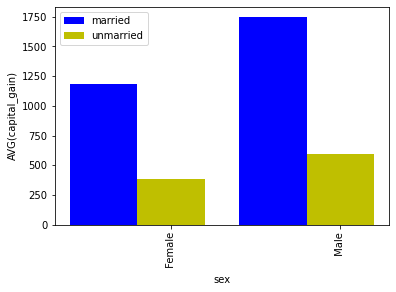

In [109]:
curs.execute("""create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');""")
con.commit()

curs.execute("select sex, avg(capital_gain) from married group by sex;")
target = curs.fetchall()

curs.execute("select sex, avg(capital_gain) from unmarried group by sex;")
reference = curs.fetchall()

def create_plot(afm, reference, target):
    group_attr,function, measure = afm
    plt.subplots()
    graph1 = plt.bar(np.arange(len(target)), target.values(), 0.4, color = 'b', label = 'married')
    graph2 = plt.bar(np.arange(len(target))+0.4, reference.values(), 0.4, color = 'y', label = 'unmarried')
    
    plt.xlabel('{}'.format(group_attr))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(np.arange(len(target))+0.4, target.keys(), rotation=90)
    plt.legend()

    plt.show()

afm_plot = ('sex', 'AVG', 'capital_gain')
create_plot(afm_plot, dict(reference), dict(target))

In [104]:
def normalize(data):
    return data.reshape(-1)

#K-L divergence
def kl_divergence(ref_data, tar_data):
    ref_nor = normalize(ref_data)
    tar_nor = normalize(tar_data)
    pro_ref = [i/np.sum(ref_nor) for i in ref_nor if sum(ref_nor)>0]
    pro_tar = [i/np.sum(tar_nor) for i in tar_nor if sum(tar_nor)>0]
    kl = np.sum([qi  * np.log(qi/pi) for qi, pi in zip(pro_tar, pro_ref) if pi>0 and qi>0])
    return kl

In [40]:
#phased execution

for i in range(10):
    curs.execute("""create or replace view test{}_married as 
                   select * from test{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view test{}_unmarried as 
                   select * from test{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1))
    con.commit()

In [115]:
group_by_col = ["economic_indicator", "workclass", "occupation", "education", "race", "native_country", "sex", "relationship"]
measure_col = ["capital_loss", "capital_gain", "age", "fnlwgt", "hours_per_week"]

views = {pos:combo for pos, combo in enumerate(list(iter.product(measure_col, group_by_col)))}

{0: ('capital_loss', 'economic_indicator'), 1: ('capital_loss', 'workclass'), 2: ('capital_loss', 'occupation'), 3: ('capital_loss', 'education'), 4: ('capital_loss', 'race'), 5: ('capital_loss', 'native_country'), 6: ('capital_loss', 'sex'), 7: ('capital_loss', 'relationship'), 8: ('capital_gain', 'economic_indicator'), 9: ('capital_gain', 'workclass'), 10: ('capital_gain', 'occupation'), 11: ('capital_gain', 'education'), 12: ('capital_gain', 'race'), 13: ('capital_gain', 'native_country'), 14: ('capital_gain', 'sex'), 15: ('capital_gain', 'relationship'), 16: ('age', 'economic_indicator'), 17: ('age', 'workclass'), 18: ('age', 'occupation'), 19: ('age', 'education'), 20: ('age', 'race'), 21: ('age', 'native_country'), 22: ('age', 'sex'), 23: ('age', 'relationship'), 24: ('fnlwgt', 'economic_indicator'), 25: ('fnlwgt', 'workclass'), 26: ('fnlwgt', 'occupation'), 27: ('fnlwgt', 'education'), 28: ('fnlwgt', 'race'), 29: ('fnlwgt', 'native_country'), 30: ('fnlwgt', 'sex'), 31: ('fnlwgt'

In [135]:
def share_based_optimization(tables, views):
    kl_dict={}
    for table in tables:
        for i, (m, a) in views.items():
            query="create or replace view vi_{} as select {}, {}({}),{}({}),{}({}) from {} group by {};".format(table+"_"+str(i),a,"sum",m,"count",m,"avg",m,table,a)
            curs.execute(query)
            con.commit()
            kl_dict[a+"-"+m]=["vi_"+str(table+"_"+str(i))]
    return kl_dict


tgt - 
            workclass         v0
23        Without-pay  58.111111
24       Never-worked  30.000000
25          Local-gov  43.949458
26                  ?  52.128240
27        Federal-gov  44.612524
28   Self-emp-not-inc  46.759207
29          State-gov  43.124807
30            Private  41.089924
31       Self-emp-inc  47.560325
ref - 
            workclass         v0
23        Without-pay  29.200000
24       Never-worked  19.000000
25          Local-gov  39.278173
26                  ?  33.538531
27        Federal-gov  40.289532
28   Self-emp-not-inc  40.889032
29          State-gov  35.747304
30            Private  32.902653
31       Self-emp-inc  40.779528
tmp - 
            workclass     v0_tgt     v0_ref
23        Without-pay  58.111111  29.200000
24       Never-worked  30.000000  19.000000
25          Local-gov  43.949458  39.278173
26                  ?  52.128240  33.538531
27        Federal-gov  44.612524  40.289532
28   Self-emp-not-inc  46.759207  40.889032
29         

6     Male  39.612796
tmp - 
       sex    v21_tgt    v21_ref
5   Female  36.974073  36.245548
6     Male  44.016369  39.612796
tgt val - 
[36.9740726  44.01636873]
ref val - 
[36.24554815 39.61279633]
tgt - 
                 native_country        v22
47                     Cambodia  41.000000
48                        Haiti  36.363636
49                         Cuba  39.862069
50                      Jamaica  40.833333
51           Dominican-Republic  44.323529
52                         Peru  35.333333
53                        South  47.674419
54                     Honduras  33.666667
55                       Taiwan  41.034483
56                         Hong  41.571429
57                        China  38.827586
58                        Italy  43.830189
59                    Nicaragua  40.000000
60                      Ecuador  39.812500
61                         Iran  45.384615
62                      Hungary  43.333333
63                  Philippines  40.942623
64               

tmp - 
                  race     v36_tgt    v36_ref
0                Black   74.461803  52.066939
1                Other   83.781955  39.181159
2   Asian-Pac-Islander  129.934859  57.895745
3                White  120.432659  58.943118
4   Amer-Indian-Eskimo   54.000000  18.771429
tgt val - 
[ 74.46180258  83.78195489 129.93485915 120.432659    54.        ]
ref val - 
[52.06693919 39.18115942 57.89574468 58.94311803 18.77142857]
tgt - 
       sex         v37
5   Female   89.469884
6     Male  121.549429
ref - 
       sex        v37
5   Female  52.665173
6     Male  62.526893
tmp - 
       sex     v37_tgt    v37_ref
5   Female   89.469884  52.665173
6     Male  121.549429  62.526893
tgt val - 
[ 89.46988432 121.54942925]
ref val - 
[52.66517262 62.52689268]
tgt - 
                 native_country         v38
47                     Cambodia    0.000000
48                        Haiti  146.590909
49                         Cuba   90.931034
50                      Jamaica    0.000000
51   

46   Handlers-cleaners  170943170.0
tmp - 
            occupation      v50_tgt      v50_ref
32        Craft-repair  514130020.0  272834530.0
33    Transport-moving  202725780.0  101289456.0
34   Machine-op-inspct  215831680.0  174177500.0
35     Exec-managerial  470373630.0  279306940.0
36        Armed-Forces     593444.0    1345389.0
37     Farming-fishing  104521696.0   64306716.0
38      Prof-specialty  421174600.0  344856300.0
39                   ?  139227460.0  208470480.0
40     Priv-house-serv    6291308.0   23281724.0
41        Adm-clerical  227143410.0  496588580.0
42       Other-service  184943140.0  435693220.0
43        Tech-support   83213390.0   94946130.0
44               Sales  334322180.0  362410940.0
45     Protective-serv   79616624.0   51507296.0
46   Handlers-cleaners  108832370.0  170943170.0
tgt val - 
[5.14130020e+08 2.02725780e+08 2.15831680e+08 4.70373630e+08
 5.93444000e+05 1.04521696e+08 4.21174600e+08 1.39227460e+08
 6.29130800e+06 2.27143410e+08 1.8494314

tgt - 
       sex       v61
5   Female   92694.0
6     Male  613104.0
ref - 
       sex       v61
5   Female  299207.0
6     Male  310802.0
tmp - 
       sex   v61_tgt   v61_ref
5   Female   92694.0  299207.0
6     Male  613104.0  310802.0
tgt val - 
[ 92694. 613104.]
ref val - 
[299207. 310802.]
tgt - 
                 native_country       v62
47                     Cambodia     492.0
48                        Haiti     800.0
49                         Cuba    2312.0
50                      Jamaica    1470.0
51           Dominican-Republic    1507.0
52                         Peru     530.0
53                        South    2050.0
54                     Honduras     202.0
55                       Taiwan    1190.0
56                         Hong     582.0
57                        China    2252.0
58                        Italy    2323.0
59                    Nicaragua     600.0
60                      Ecuador     637.0
61                         Iran    1180.0
62                     

tgt - 
       relationship        v75
90        Own-child    15496.0
91        Unmarried    22326.0
92             Wife   185034.0
93   Other-relative     7728.0
94    Not-in-family    48724.0
95          Husband  1638055.0
ref - 
       relationship       v75
91        Own-child  184750.0
92        Unmarried  120562.0
93   Other-relative   42629.0
94    Not-in-family  577396.0
tmp - 
       relationship  v75_tgt   v75_ref
90        Own-child  15496.0  184750.0
91        Unmarried  22326.0  120562.0
93   Other-relative   7728.0   42629.0
94    Not-in-family  48724.0  577396.0
tgt val - 
[15496. 22326.  7728. 48724.]
ref val - 
[184750. 120562.  42629. 577396.]
tgt - 
                  race        v76
0                Black    86748.0
1                Other    11143.0
2   Asian-Pac-Islander    73803.0
3                White  1738325.0
4   Amer-Indian-Eskimo     7344.0
ref - 
                  race       v76
0                Black  101895.0
1                Other    5407.0
2   Asian-Pac-

89              <=50K   564868.0
ref - 
   economic_indicator       v79
89               >50K  176512.0
90              <=50K  748825.0
tmp - 
   economic_indicator    v79_tgt   v79_ref
88               >50K  1352495.0  176512.0
89              <=50K   564868.0  748825.0
tgt val - 
[1352495.  564868.]
ref val - 
[176512. 748825.]
tgt - 
            workclass   v80
23        Without-pay  29.0
24       Never-worked  30.0
25          Local-gov  20.0
26                  ?  18.0
27        Federal-gov  19.0
28   Self-emp-not-inc  18.0
29          State-gov  20.0
30            Private  17.0
31       Self-emp-inc  22.0
ref - 
            workclass   v80
23        Without-pay  19.0
24       Never-worked  17.0
25          Local-gov  17.0
26                  ?  17.0
27        Federal-gov  17.0
28   Self-emp-not-inc  17.0
29          State-gov  17.0
30            Private  17.0
31       Self-emp-inc  17.0
tmp - 
            workclass  v80_tgt  v80_ref
23        Without-pay     29.0     19.0
24     

tgt - 
       relationship      v91
90        Own-child  31387.0
91        Unmarried  20057.0
92             Wife  19395.0
93   Other-relative  23686.0
94    Not-in-family  20534.0
95          Husband  13769.0
ref - 
       relationship      v91
91        Own-child  19752.0
92        Unmarried  19410.0
93   Other-relative  20057.0
94    Not-in-family  12285.0
tmp - 
       relationship  v91_tgt  v91_ref
90        Own-child  31387.0  19752.0
91        Unmarried  20057.0  19410.0
93   Other-relative  23686.0  20057.0
94    Not-in-family  20534.0  12285.0
tgt val - 
[31387. 20057. 23686. 20534.]
ref val - 
[19752. 19410. 20057. 12285.]
tgt - 
                  race      v92
0                Black  23494.0
1                Other  25610.0
2   Asian-Pac-Islander  14878.0
3                White  19302.0
4   Amer-Indian-Eskimo  13769.0
ref - 
                  race      v92
0                Black  19752.0
1                Other  24562.0
2   Asian-Pac-Islander  20057.0
3                White  1

46   Handlers-cleaners   2.0
ref - 
            occupation   v98
32        Craft-repair   1.0
33    Transport-moving  10.0
34   Machine-op-inspct   1.0
35     Exec-managerial   3.0
36        Armed-Forces   8.0
37     Farming-fishing   6.0
38      Prof-specialty   2.0
39                   ?   1.0
40     Priv-house-serv   4.0
41        Adm-clerical   1.0
42       Other-service   1.0
43        Tech-support   3.0
44               Sales   2.0
45     Protective-serv   3.0
46   Handlers-cleaners   5.0
tmp - 
            occupation  v98_tgt  v98_ref
32        Craft-repair      2.0      1.0
33    Transport-moving      5.0     10.0
34   Machine-op-inspct      7.0      1.0
35     Exec-managerial      1.0      3.0
36        Armed-Forces     40.0      8.0
37     Farming-fishing      2.0      6.0
38      Prof-specialty      1.0      2.0
39                   ?      1.0      1.0
40     Priv-house-serv      8.0      4.0
41        Adm-clerical      2.0      1.0
42       Other-service      2.0      1.0
4

ref - 
                  race  v108
0                Black   0.0
1                Other   0.0
2   Asian-Pac-Islander   0.0
3                White   0.0
4   Amer-Indian-Eskimo   0.0
tmp - 
                  race  v108_tgt  v108_ref
0                Black       0.0       0.0
1                Other       0.0       0.0
2   Asian-Pac-Islander       0.0       0.0
3                White       0.0       0.0
4   Amer-Indian-Eskimo       0.0       0.0
tgt val - 
[0. 0. 0. 0. 0.]
ref val - 
[0. 0. 0. 0. 0.]
tgt - 
       sex  v109
5   Female   0.0
6     Male   0.0
ref - 
       sex  v109
5   Female   0.0
6     Male   0.0
tmp - 
       sex  v109_tgt  v109_ref
5   Female       0.0       0.0
6     Male       0.0       0.0
tgt val - 
[0. 0.]
ref val - 
[0. 0.]
tgt - 
                 native_country  v110
47                     Cambodia   0.0
48                        Haiti   0.0
49                         Cuba   0.0
50                      Jamaica   0.0
51           Dominican-Republic   0.0
52       

ref val - 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tgt - 
            occupation  v114
32        Craft-repair   0.0
33    Transport-moving   0.0
34   Machine-op-inspct   0.0
35     Exec-managerial   0.0
36        Armed-Forces   0.0
37     Farming-fishing   0.0
38      Prof-specialty   0.0
39                   ?   0.0
40     Priv-house-serv   0.0
41        Adm-clerical   0.0
42       Other-service   0.0
43        Tech-support   0.0
44               Sales   0.0
45     Protective-serv   0.0
46   Handlers-cleaners   0.0
ref - 
            occupation  v114
32        Craft-repair   0.0
33    Transport-moving   0.0
34   Machine-op-inspct   0.0
35     Exec-managerial   0.0
36        Armed-Forces   0.0
37     Farming-fishing   0.0
38      Prof-specialty   0.0
39                   ?   0.0
40     Priv-house-serv   0.0
41        Adm-clerical   0.0
42       Other-service   0.0
43        Tech-support   0.0
44               Sales   0.0
45     Protective-serv   0.0
46   Handlers-cleaners   0

31       Self-emp-inc  83.0
tmp - 
            workclass  v120_tgt  v120_ref
23        Without-pay      72.0      65.0
24       Never-worked      30.0      23.0
25          Local-gov      90.0      84.0
26                  ?      90.0      90.0
27        Federal-gov      90.0      79.0
28   Self-emp-not-inc      90.0      90.0
29          State-gov      75.0      81.0
30            Private      90.0      90.0
31       Self-emp-inc      84.0      83.0
tgt val - 
[72. 30. 90. 90. 90. 90. 75. 90. 84.]
ref val - 
[65. 23. 84. 90. 79. 90. 81. 90. 83.]
tgt - 
        education  v121
7    Some-college  90.0
8      Assoc-acdm  90.0
9       Bachelors  90.0
10           11th  90.0
11            9th  77.0
12        HS-grad  90.0
13           12th  73.0
14        7th-8th  90.0
15           10th  90.0
16      Assoc-voc  80.0
17        5th-6th  84.0
18    Prof-school  90.0
19      Doctorate  80.0
20      Preschool  65.0
21        Masters  90.0
22        1st-4th  81.0
ref - 
        education  v121
7

88                   Yugoslavia   191230.0
tmp - 
                 native_country   v134_tgt   v134_ref
47                     Cambodia   355856.0   292472.0
48                        Haiti   343872.0   348092.0
49                         Cuba   505119.0   366232.0
50                      Jamaica   401623.0   387116.0
51           Dominican-Republic   320513.0   331875.0
52                         Peru   551962.0   506436.0
53                        South   337505.0   375422.0
54                     Honduras   308493.0   411587.0
55                       Taiwan   506329.0   332008.0
56                         Hong   356015.0   330466.0
57                        China   399246.0   324654.0
58                        Italy   573583.0   353263.0
59                    Nicaragua   849857.0   544686.0
60                      Ecuador   313945.0   224870.0
61                         Iran   454508.0   406603.0
62                      Hungary   258883.0   358975.0
63                  Philippines 

22        1st-4th    7688.0    3674.0
tgt val - 
[99999. 99999. 99999.  9386.  5178. 99999. 15024. 10566. 99999. 99999.
  7298. 99999. 99999. 41310. 99999.  7688.]
ref val - 
[99999. 14344. 99999. 14344. 99999. 99999. 18481.  6097. 34095. 27828.
  6497. 99999. 99999.     0. 99999.  3674.]
tgt - 
            occupation     v146
32        Craft-repair  99999.0
33    Transport-moving  99999.0
34   Machine-op-inspct  99999.0
35     Exec-managerial  99999.0
36        Armed-Forces      0.0
37     Farming-fishing  41310.0
38      Prof-specialty  99999.0
39                   ?  99999.0
40     Priv-house-serv   4508.0
41        Adm-clerical  99999.0
42       Other-service  99999.0
43        Tech-support  99999.0
44               Sales  99999.0
45     Protective-serv  15024.0
46   Handlers-cleaners  99999.0
ref - 
            occupation     v146
32        Craft-repair  99999.0
33    Transport-moving  15831.0
34   Machine-op-inspct  14344.0
35     Exec-managerial  99999.0
36        Armed-Forces  

46   Handlers-cleaners    2179.0    2824.0
tgt val - 
[2603. 2603. 2415. 2824. 1887. 2457. 3900. 2603. 1594. 3770. 2603. 2051.
 2824. 2339. 2179.]
ref val - 
[3004. 2824. 3900. 4356.    0. 2339. 3683. 4356. 1602. 2547. 3770. 2444.
 2754. 2444. 2824.]
tgt - 
       relationship    v155
90        Own-child  3900.0
91        Unmarried  3770.0
92             Wife  2457.0
93   Other-relative  2339.0
94    Not-in-family  2824.0
95          Husband  2603.0
ref - 
       relationship    v155
91        Own-child  2339.0
92        Unmarried  4356.0
93   Other-relative  3683.0
94    Not-in-family  4356.0
tmp - 
       relationship  v155_tgt  v155_ref
90        Own-child    3900.0    2339.0
91        Unmarried    3770.0    4356.0
93   Other-relative    2339.0    3683.0
94    Not-in-family    2824.0    4356.0
tgt val - 
[3900. 3770. 2339. 2824.]
ref val - 
[2339. 4356. 3683. 4356.]
tgt - 
                  race    v156
0                Black  2377.0
1                Other  2179.0
2   Asian-Pac-Isla

ref - 
       relationship  v171
91        Own-child  4824
92        Unmarried  2864
93   Other-relative   769
94    Not-in-family  7644
tmp - 
       relationship  v171_tgt  v171_ref
90        Own-child       240      4824
91        Unmarried       581      2864
93   Other-relative       212       769
94    Not-in-family       648      7644
tgt val - 
[240 581 212 648]
ref val - 
[4824 2864  769 7644]
tgt - 
                  race   v172
0                Black   1165
1                Other    133
2   Asian-Pac-Islander    568
3                White  14434
4   Amer-Indian-Eskimo    136
ref - 
                  race   v172
0                Black   1957
1                Other    138
2   Asian-Pac-Islander    470
3                White  13361
4   Amer-Indian-Eskimo    175
tmp - 
                  race  v172_tgt  v172_ref
0                Black      1165      1957
1                Other       133       138
2   Asian-Pac-Islander       568       470
3                White     14434     1336

90              <=50K  15062
tmp - 
   economic_indicator  v183_tgt  v183_ref
88               >50K      6800      1039
89              <=50K      9636     15062
tgt val - 
[6800 9636]
ref val - 
[ 1039 15062]
tgt - 
            workclass   v184
23        Without-pay      9
24       Never-worked      1
25          Local-gov   1108
26                  ?    733
27        Federal-gov    511
28   Self-emp-not-inc   1765
29          State-gov    649
30            Private  10798
31       Self-emp-inc    862
ref - 
            workclass   v184
23        Without-pay      5
24       Never-worked      6
25          Local-gov    985
26                  ?   1103
27        Federal-gov    449
28   Self-emp-not-inc    775
29          State-gov    649
30            Private  11875
31       Self-emp-inc    254
tmp - 
            workclass  v184_tgt  v184_ref
23        Without-pay         9         5
24       Never-worked         1         6
25          Local-gov      1108       985
26                  ?

tgt - 
                  race   v196
0                Black   1165
1                Other    133
2   Asian-Pac-Islander    568
3                White  14434
4   Amer-Indian-Eskimo    136
ref - 
                  race   v196
0                Black   1957
1                Other    138
2   Asian-Pac-Islander    470
3                White  13361
4   Amer-Indian-Eskimo    175
tmp - 
                  race  v196_tgt  v196_ref
0                Black      1165      1957
1                Other       133       138
2   Asian-Pac-Islander       568       470
3                White     14434     13361
4   Amer-Indian-Eskimo       136       175
tgt val - 
[ 1165   133   568 14434   136]
ref val - 
[ 1957   138   470 13361   175]
tgt - 
       sex   v197
5   Female   2507
6     Male  13929
ref - 
       sex  v197
5   Female  8255
6     Male  7846
tmp - 
       sex  v197_tgt  v197_ref
5   Female      2507      8255
6     Male     13929      7846
tgt val - 
[ 2507 13929]
ref val - 
[8255 7846]
tgt - 
 

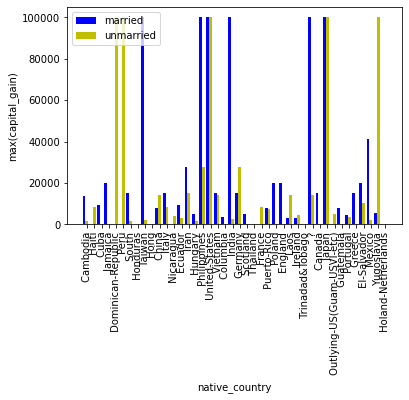

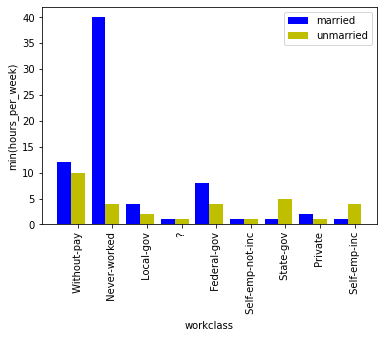

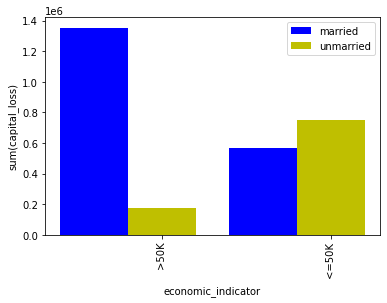

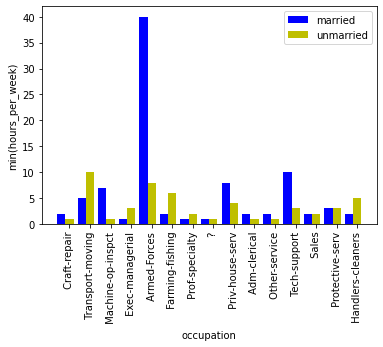

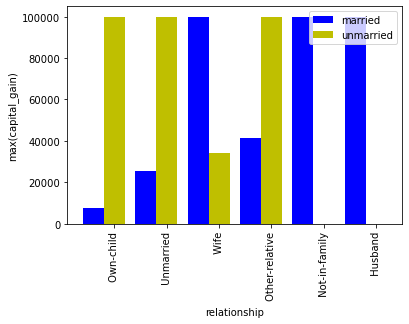

In [150]:
functions = ["avg", "sum", "min", "max", "count"]
attributes = ["workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"]
measurements = ["age", "fnlwgt", "hours_per_week", "capital_gain", "capital_loss"]

views2 = {k: v for k,v in enumerate(list(iter.product(functions, measurements, attributes)))}


def sharing_based_query(views, tables):
    select_a_str = []
    select_m_str = []
    group_by_str = []
    for i, (f, m, a) in views.items():
        select_a_str.append('{}'.format(a))
        select_m_str.append('{}({}) as v{}'.format(f, m, i))
        group_by_str.append('{}'.format(a))
    
    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_a_str, select_m_str, table, group_by_str)
        curs.execute(query)
        data.append(curs.fetchall())
    cols = [desc[0] for desc in curs.description]
    return data, cols

tables = ['married', 'unmarried']
data, cols = sharing_based_query(views2, tables)

tgt_df = pd.DataFrame(data[0], columns=cols)
ref_df = pd.DataFrame(data[1], columns=cols)

view_scores = {}
for vid, (f, m, a) in views2.items():
    tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
    print('tgt - ')
    print(tgt)
    ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
    print('ref - ')
    print(ref)
    tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')
    print('tmp - ')
    print(tmp)
    
    tgt_val = tmp['v{}_tgt'.format(vid)].values
    print('tgt val - ')
    print(tgt_val)
    ref_val = tmp['v{}_ref'.format(vid)].values
    print('ref val - ')
    print(ref_val)
    
    score = kl_divergence(tgt_val, ref_val)
    view_scores[vid] = score

views_ranking = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)

def top_k_views(ranking, k):
    for vid in ranking[:k]:
        f, m, a = views2[vid]

        query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(a, f, m, a)
        curs.execute(query)
        tgt_rows = curs.fetchall()

        query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(a, f, m, a)
        curs.execute(query)
        ref_rows = curs.fetchall()

        tgt_dict = dict(tgt_rows)
        ref_dict = dict(ref_rows)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0

        create_plot((a, f, m), ref_dict, tgt_dict)

K = 5
top_k_views([r[0] for r in views_ranking], K)